# Final Project:<br>
# Applied Machine Learning for Horizontal Wells Risk Assessment Optimization<br>
## Team:<br>
## Ghaleb Al-Gobi, ID# 2138623<br> 
## Neenu Achu Eapen, ID# 2153382<br> 
## Purva Dixitkumar Desai, ID# 1826341<br> 
## Sai charan S Pendyala, ID# 2093975<br>
## Sri Divya Mandadapu , ID# 2211703<br> 
## Vom Siri Krrishna Jorige, ID# 2211625<br>


In [3]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display, HTML
#display(HTML("<style>.container { width:110% !important; }</style>"))

In [4]:
# # prompt to load a file
# root = tk.Tk()
# root.withdraw()

# file_path = filedialog.askopenfilename()

In [5]:
Survey_Data = pd.read_excel('Directional Surveys Data.xlsx')

In [6]:
# # wellids means the array of the well IDs
# wellids = Survey_Data['WellID'].unique()

In [7]:
def frimd(file):
    '''Find and remove the index of the rows of the missing data'''
    if file.isna().any().any():
        # file_Data_columns means the columns of file 
        # without (not including VerticalSection_FT)
        file_Data_columns = list(file.columns)
        # imd means the index of the rows with missing data (not including VerticalSection_FT)
        imd = []
        # cwmd means the index of the culomns with missing data (not including VerticalSection_FT)
        cwmd = []
        for i in range(len(file_Data_columns)):
            if file[file_Data_columns[i]].isna().any():
                imd.append(file[file[file_Data_columns[i]].isna()].index)
                cwmd.append(file_Data_columns[i])
        imd = [imd[0] for imd in imd]
        file.drop(index=imd, inplace = True)
        Missing_data=pd.DataFrame({"Rows with missing data": imd, 
                                   "Culomns with missing data": cwmd})
        return Missing_data

    return
    

In [8]:
def frdd(file):
    '''Find and remove the duplicated data'''
    if file.duplicated().any().any():
        identical_rows = file[file.duplicated(keep=False)].index
        # identical_rows = [identical_rows[0] for identical_rows in identical_rows]
        duplicated_rows = pd.DataFrame({"Rows with duplicated data": identical_rows})
        # Remove duplicated data
        file.drop_duplicates(inplace = True)
        return duplicated_rows
    return

In [9]:
frimd(Survey_Data)

In [10]:
frdd(Survey_Data)

In [11]:
def stn(file):
    '''Sort the station numbers for each well separately'''
    wellids = file['WellID'].unique()
    for i in wellids:
        # when the StationNumber for a given well does not have duplicates
        if not file[file['WellID'] == i]['StationNumber'].duplicated().any():
            # we need to find the number of the rows at which the well starts and ends
            # note that the index of the row is different from the row number after deleting
            # missing and duplicated data
            # (In summary left_index and right_index give the iloc coordinates for a given well)
            # left_iloc_index means the iloc index at which the well starts
            left_iloc_index = file.index.get_loc(file[(file['WellID'] == i)].index[0])
            # right_iloc_index means the iloc index at which the well ends
            right_iloc_index = file.index.get_loc(file[(file['WellID'] == i)].index[-1])
            file.iloc[left_iloc_index:right_iloc_index] = file.iloc[left_iloc_index:right_iloc_index].sort_values(
                by=['StationNumber'])
    return

In [12]:
stn(Survey_Data)

In [13]:
# # dimdd_keys means the keys of the dictionary dimdd (the lock position of the target MD)
# dimdd_keys=[]
# # wst means wells with side tracks
# wst = []
def fimddwst(file):
    '''Find the indeces where the target MD decreases and the well IDs with side tracks'''
    global dimdd_keys, wst
    # dimdd means the dictionary of the indeces (for loc function) at which the MD is decreasing
    dimdd = {}
    wellids = file['WellID'].unique()
    for j in wellids:
        # dmd means find the difference between measured depth (each two points)
        dmd = []
        for i in range(1,len(file[file['WellID'] == j]['MeasuredDepth_FT'])):
            # The range in this loop starts from 1 (not from 0) and subrtract each (ith - (i-1)th)
            # This will result in a list that is shorter than the well-list by 1 element
            dmd.append(file[file['WellID'] == j]['MeasuredDepth_FT'].iloc[i] - 
            file[file['WellID'] == j]['MeasuredDepth_FT'].iloc[i-1])
        # fist_match means the first element wher dmd is less than zero

        first_match = next((item for item in dmd if item < 0), None)
        # Based on the loop, the index of the value of first_match is less by 1 than the index of the targetted MD.
        # In odred to find the dataframe index of targetted MD based on the index of the dmd list,
        # we need to use .index[dmd.index(first_match)+1]
        if first_match == None:
            pass
        else:
            # tmddi means the target MD dataframe index (loc index)
            tmddi = file[file['WellID'] == j].index[dmd.index(first_match)+1]
            dimdd[tmddi] = file[file['WellID'] == j]['MeasuredDepth_FT'].loc[tmddi]       

    # dimdd_keys means the keys of the dictionary dimdd (the lock position of the target MD)
    dimdd_keys = list(dimdd.keys())

    # wst means wells with side tracks
    wst = []
    for i in range(0, len(dimdd_keys)):
        wst.append(file.loc[list(dimdd.keys())[i]]['WellID'])
    return


In [14]:
fimddwst(Survey_Data)

In [15]:
def fstsaob(file):
    '''Find the number of the sids track sections and whether they are before or after the target MD'''
    global nsts, stboa, stbtmd, statmd
    # stbtmd means the number of sections of the side track before the target MD (used as iloc indexer)
    # or combine it with dimdd_keys to use it as loc indexr
    stbtmd = []
    # st means the number of sections in the side track after the target MD (used as iloc indexer)
    statmd = []
    for i in range(0,len(wst)):
        # left_loc_index means the loc index at which the well starts
        left_loc_index = file[(file['WellID'] == wst[i])].index[0]
        # right_loc_index means the loc index at which the well ends
        right_loc_index = file[(file['WellID'] == wst[i])].index[-1]
        # temp_dmd means the difference between measured depth (each two points) in the while loop
        # it is different from dmd which is a list while temp_dmd is an number
        temp_dmd = -1
        # s means the step increment and will increase untill it reaches the end of the side track
        s = 1
        while temp_dmd < 0:
            temp_dmd = file.loc[
                left_loc_index:right_loc_index]['MeasuredDepth_FT'].loc[dimdd_keys[i]] - file.loc[
                left_loc_index:right_loc_index]['MeasuredDepth_FT'].loc[dimdd_keys[i]-s]

            s+=1
        stbtmd.append(s-1)
        statmd.append(right_loc_index-dimdd_keys[i]+1)
    # nsts means number of side track sections
    nsts = []
    # ba means the side track is before or after target MD
    stboa = []
    stbtmd
    statmd
    for i in range(0, len(wst)):
        # if the side track or repetative data is before the target MD then:
        if stbtmd[i] <= statmd[i]:
            # append the number of side track sections before the target MD
            nsts.append(stbtmd[i])
            # append the location of the side track before the target MD
            stboa.append('before')
        # if the side track or repetative data is below the target MD then:
        elif stbtmd[i] > statmd[i]:
            # append the number of side track sections after the target MD
            nsts.append(statmd[i])
            # append the location of the side track after the target MD
            stboa.append('after')
    return



In [16]:
fstsaob(Survey_Data)

In [17]:
def dstd(file):
    '''Drop the side track sections (data row)'''
    # Drop the side track rows (each side track has an element number from dimdd_keys)
    # Drop them using the location the of target MD (dimdd_keys) and the number side 
    # track sections ST. This now should clean the data
    for i in range(0, len(wst)):
        # if the side track or repetative data are above the target MD then:
        if nsts[i] in stbtmd:
            # drop the side track rows before the target MD using the loc indexer
            file.drop(file.loc[dimdd_keys[i]-stbtmd[i]:dimdd_keys[i]-1].index, inplace = True)
        # if the side track or repetative data are below the target MD then:
        elif nsts[i] in statmd:
            # drop the side track rows after the target MD  using the loc indexer
            file.drop(file[file['WellID'] == wst[i]].loc[dimdd_keys[i]:dimdd_keys[i]+statmd[i]-1
                                                                              ].index, inplace = True)
    return

In [18]:
dstd(Survey_Data)

In [19]:
# Possible_side_track_Data means the dataframe that contains the data of the wells 
# with POSSIBLE side tracks (this is before reindexing)
Possible_side_track_Data = pd.DataFrame({'Wells with sidetrack or bad MD data': wst,
                                         'Indeces of target MD test point': dimdd_keys,
                                         'Number of side track sections': nsts,
                                         'is the side track before or after the target MD?':stboa})

In [20]:
def delta_inc(file):
    '''Add the delta_inclination between every other point on the ilination column'''
    delta_inclination = []
    wellids = file['WellID'].unique()
    for j in wellids:
        delta_inclination += [0, 0]
        for i in range(2,len(file[file['WellID'] == j])):
            delta_inclination.append(file[file['WellID'] == j]['Inclination_DEG'].iloc[i]-
                                     file[file['WellID'] == j]['Inclination_DEG'].iloc[i-2])

    file['Delta Inclination'] = delta_inclination
    return

In [21]:
delta_inc(Survey_Data)

In [22]:
# save a copy of the data beofre reindexing on the next function
Survey_Data_before_reindexing = Survey_Data

In [23]:
def summary_svl(data):
    '''This function output a dataframe that includes the following data:
    ['WellID', 'Index of the First Section of the Well',
    'Index of the Last Section of the Well',
    'Total MD', 'TVD', 'KOP Index', 'TVD at KOP', 'Lateral Heel index',
    'MD at Lateral Heel',
    'Step-out', 'Lateral Section Length']'''
    # first reindex the whole data frame since it has been processed above
    new_index = list(range(0,len(data),1))
    data = data.reindex(new_index)
    svl = pd.DataFrame({'WellID': data['WellID'].unique()})
    # well_fi means index of the first section of the well
    well_fi = []
    # well_li means index of the last section of the well
    well_li = []
    for i in list(range(0,len(svl))):
        try:
        # this next line it based on the criteria of the index at the KOP. If the KOP does not exsist based on the
        # criteria, then we should make the whole row as "NaN". To beter understand this, please review the cod for
        # the variable KOP_index
            data[(data['WellID'] == svl.iloc[i,0]) & 
                                              (data['Delta Inclination'] > 6)].index[0]
            well_fi.append(data[(data['WellID'] == svl.iloc[i,0])].index[0])
            well_li.append(data[(data['WellID'] == svl.iloc[i,0])].index[-1])
        except IndexError:
            well_fi.append("NaN")
            well_li.append("NaN")
    svl['Index of the First Section of the Well'] = pd.DataFrame(well_fi)
    svl['Index of the Last Section of the Well'] = pd.DataFrame(well_li)
    # TMD means total measured depth
    TMD = []
    # TVD means true vertical depth at the end of the well
    TVD = []
    for i in list(range(0,len(svl))):
        if svl['Index of the First Section of the Well'][i] == 'NaN':
            TMD.append("NaN")
            TVD.append("NaN")
        else:
            TMD.append(data.iloc[svl.iloc[i,2],6])
            TVD.append(data.iloc[svl.iloc[i,2],3])
    svl['Total MD'] = pd.DataFrame(TMD)
    svl['TVD'] = pd.DataFrame(TVD)
    # KOP index
    KOP_index = []
    for i in list(range(0,len(svl))):
        try:
            KOP_index.append(data[(data['WellID'] == svl.iloc[i,0]) & 
                                              (data['Delta Inclination'] > 6)].index[0])
        except IndexError:
            KOP_index.append("NaN")
    svl['KOP Index'] = pd.DataFrame(KOP_index)
    # TVD_KOP means TVD at KOP
    TVD_KOP = []
    for i in list(range(0,len(svl))):
        if svl.iloc[i,5] != 'NaN':
            TVD_KOP.append(data.iloc[svl.iloc[i,5],3])
        else:
            TVD_KOP.append('NaN')
    svl['TVD at KOP'] = pd.DataFrame(TVD_KOP)
    # lh_index means Lateral Heel index
    lh_index = []
    for i in list(range(0,len(svl))):
        try:
            lh_index.append(data[(data['WellID'] == svl.iloc[i,0]) & 
                                              (data['Inclination_DEG'] > 80)].index[0])
        except IndexError:
            lh_index.append("NaN")
    svl['Lateral Heel index'] = pd.DataFrame(lh_index) 
    # MD_LH means MD at Lateral Heel
    MD_LH = []
    for i in list(range(0,len(svl))):
        if svl.iloc[i,7] != 'NaN':
            MD_LH.append(data.iloc[svl.iloc[i,7],6])
        else:
            MD_LH.append('NaN')
    svl['MD at Lateral Heel'] = pd.DataFrame(MD_LH)
    # stepout is the Step-out for each well
    stepout = []
    for j in range(0,len(svl['WellID'])):
        if svl.iloc[j,1] != 'NaN':
            # h_Sections is the horizontal projection of the any well section
            h_Sections = []
            for i in range(svl.iloc[j,1]+1, svl.iloc[j,5]+1):h_Sections.append(
                (data.iloc[i,6]-data.iloc[i-1,6])*np.sin(np.radians(data.iloc[i-1,4])))
            stepout.append(sum(h_Sections))
        else:
            stepout.append("NaN")
    svl['Step-out'] = pd.DataFrame(stepout)
    # lsl means Lateral Section Length
    lsl = []
    for i in list(range(0,len(svl))):
        if svl['KOP Index'][i] == 'NaN':
            lsl.append("NaN")
        else:
            lsl.append(svl.iloc[i,3]-svl.iloc[i,8])
    svl['Lateral Section Length'] = pd.DataFrame(lsl) 
    return svl

In [24]:
Summary_sheet = summary_svl(Survey_Data)
Summary_sheet.drop(index=Summary_sheet[
    Summary_sheet['Lateral Section Length'].isin(['NaN'])].index, inplace = True)
Unique_Wells = list(Survey_Data['WellID'].unique())
Summary_sheet_wells = list(Summary_sheet['WellID'])
for i in Unique_Wells:
    if i not in Summary_sheet_wells:
        Survey_Data = Survey_Data.drop(Survey_Data[Survey_Data['WellID'] == i].index)


In [25]:
# create a writer object
writer = pd.ExcelWriter('Processed Data.xlsx', engine='xlsxwriter')
# write each data frame to a different sheet
Survey_Data.to_excel(writer, sheet_name='Processed Surveys Data')
Summary_sheet.to_excel(writer, sheet_name='Summary of Surveys Data')
Possible_side_track_Data.to_excel(writer, sheet_name='Wells with Sidetrack')

# save the Excel file
writer.save()
writer.close()

C:\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [26]:
# Delete the index column from the excel sheet 'Processed Surveys Data'
df = pd.read_excel('Processed Data.xlsx', sheet_name='Processed Surveys Data')

# drop the first column
df.drop(df.columns[0], axis=1, inplace=True)

# Rewrite the excel sheet 'Processed Surveys Data' to the excel file 'Processed Data.xlsx'
writer = pd.ExcelWriter('Processed Data.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Processed Surveys Data')
# write the other sheets to the same Excel file
Summary_sheet.to_excel(writer, sheet_name='Summary of Surveys Data')
Possible_side_track_Data.to_excel(writer, sheet_name='Wells with Sidetrack')
# save the Excel file
writer.save()
writer.close()


C:\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [27]:
Processed_Surveys_Data = pd.read_excel('Processed Data.xlsx', sheet_name='Processed Surveys Data')
Summary_of_Surveys_Data = pd.read_excel('Processed Data.xlsx', sheet_name='Summary of Surveys Data')
Wells_with_Sidetrack = pd.read_excel('Processed Data.xlsx', sheet_name='Wells with Sidetrack')
# Processed Surveys Data
# Summary of Surveys Data
# Wells with Sidetrack

# Standard Variables for comparison

In [28]:
# Define the inpute variables

# dpod means drill pipe OD diameter in inhes list:
dpod = [4.5]
dpod = [dpod[0]/24]
# dpw means list of drill pipe weight in pounds per foot:
dpw = [17.84]
# mw means list of mud weights used in pounds per gallon:
mw = [7.5]
# mu means list of friction factor:
mu = [0.45]
# bdpw means the buoyant drill pipe weight list:
bdpw = []
for i in range(len(mw)):
    bdpw.append(((65-mw[i])/65)*dpw[i])
# bhad means the BHA OD diameter in inches:
bhad = [6.75]
bhad = [bhad[0]/24]
# bhaw means the BHA weight in pound force:
bhaw = [8300]
# blw means the block weight in pound force
blw = [40000]
# bt means assumed bit torque in pound force-feet
bt = [11000]

In [29]:
# delta_MD means the MD section length between each two points
delta_MD = []
for i in range(len(Summary_of_Surveys_Data)):
    delta_MD.append(0)
    for j in range(1,len(Processed_Surveys_Data[Processed_Surveys_Data['WellID'] == 
                                              Summary_of_Surveys_Data['WellID'][i]])):
        delta_MD.append(
            Processed_Surveys_Data[
                Processed_Surveys_Data['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['MeasuredDepth_FT'].iloc[j]-Processed_Surveys_Data[
                Processed_Surveys_Data['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['MeasuredDepth_FT'].iloc[j-1])
        
Processed_Surveys_Data['Section Length'] = delta_MD


In [30]:
# widdel_md means the dataframe for well IDs and componeneets of hook load and torque calculations
widhlt = Processed_Surveys_Data.loc[:,['WellID', 'Inclination_DEG', 'Section Length']]

# Standarized Hook load and torque

In [31]:
# HL means the total hook load at every MD depth:
HL = []
for i in range(len(Summary_of_Surveys_Data['WellID'])):
    # af means the axial forces at every MD section:
    af = []
    for j in range(len(widhlt[widhlt['WellID']==Summary_of_Surveys_Data['WellID'][i]])):
        af.append((widhlt[widhlt['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['Section Length'].iloc[j] *
                  bdpw[0]) * (mu[0]*np.sin(np.radians(widhlt[widhlt['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['Inclination_DEG'].iloc[j])) + 
                             np.cos(np.radians(widhlt[widhlt['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['Inclination_DEG'].iloc[j]))))
        HL.append(sum(af) + blw[0] + (bhaw[0]) * (mu[0] * np.sin(np.radians(widhlt[widhlt['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['Inclination_DEG'].iloc[j])) +
                                                  np.cos(np.radians(widhlt[widhlt['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['Inclination_DEG'].iloc[j]))))
# add the hook load data to the Processed_Surveys_Data data frame
Processed_Surveys_Data['Hook Load'] = HL

# Find the max Hook load
# HLmax means the max hook load
HLmax = max(HL)

# Add the percentage of each hookload to the maximum hookload in the dataframe
# HL_percentage means hookload percentage
HL_percentage = (Processed_Surveys_Data['Hook Load'] / HLmax) * 100
# Add the HL_percentage as a new column to the DataFrame
Processed_Surveys_Data['Hook Load Percentage'] = HL_percentage

# TQ means the total torque at every MD depth:
TQ = []
for i in range(len(Summary_of_Surveys_Data['WellID'])):
    # tq means the torque at every MD section:
    tq = []
    for j in range(len(widhlt[widhlt['WellID']==Summary_of_Surveys_Data['WellID'][i]])):
        tq.append(mu[0] * dpod[0] * bdpw[0] * widhlt[widhlt['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['Section Length'].iloc[j] * np.sin(
            np.radians(widhlt[widhlt['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['Inclination_DEG'].iloc[j])))
        TQ.append(sum(tq) + bt[0] + bhaw[0] * bhad[0] * mu[0] * np.sin(np.radians(widhlt[widhlt['WellID'] == Summary_of_Surveys_Data['WellID'][i]]['Inclination_DEG'].iloc[j])))

# add the torque data to the Processed_Surveys_Data data frame
Processed_Surveys_Data['Torque'] = TQ

# Find the max torque
# TQmax means the max hook load
TQmax = max(TQ)

# Add the percentage of each torque to the maximum torque in the dataframe
# QT_percentage means torque percentage
QT_percentage = (Processed_Surveys_Data['Torque'] / TQmax) * 100
# Add the QT_percentage as a new column to the DataFrame
Processed_Surveys_Data['Torque Percentage'] = QT_percentage

In [32]:
# Hook_load means the hook load of every well
Hook_load = []
# Torque means the torque of every well
Torque = []
for i in Summary_of_Surveys_Data['WellID']:
    Hook_load.append(Processed_Surveys_Data[Processed_Surveys_Data['WellID'] == i]['Hook Load'].iloc[-1])
    Torque.append(Processed_Surveys_Data[Processed_Surveys_Data['WellID'] == i]['Torque'].iloc[-1])

# add the Hook_load and Torque data to the Summary_of_Surveys_Data data frame
TandD = {'Hook Load':Hook_load, 'Torque':Torque}
Summary_of_Surveys_Data = Summary_of_Surveys_Data.assign(**TandD)

In [33]:
# Drop the unnecessary indec column 'Unnamed: 0' from the data frames
Processed_Surveys_Data.drop(Processed_Surveys_Data.columns[0], axis=1, inplace=True)
Summary_of_Surveys_Data.drop(Summary_of_Surveys_Data.columns[0], axis=1, inplace=True)
Wells_with_Sidetrack.drop(Wells_with_Sidetrack.columns[0], axis=1, inplace=True)

In [34]:
# Rewrite the excel sheet 'Processed Surveys Data' to the excel file 'Processed Data.xlsx'
writer = pd.ExcelWriter('Processed Data-latest.xlsx', engine='xlsxwriter')
Processed_Surveys_Data.to_excel(writer, sheet_name='Processed Surveys Data')
# write the other sheets to the same Excel file
Summary_of_Surveys_Data.to_excel(writer, sheet_name='Summary of Surveys Data')
Wells_with_Sidetrack.to_excel(writer, sheet_name='Wells with Sidetrack')
# save the Excel file
writer.save()
writer.close()

C:\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


# EDA

In [35]:
# Load data into a Pandas dataframe
data = pd.read_excel('Processed Data-latest.xlsx', sheet_name='Summary of Surveys Data', usecols=['Total MD', 'TVD','TVD at KOP', 'MD at Lateral Heel', 'Step-out', 'Lateral Section Length'])

# Print the first few rows of the data
print(data.head())


   Total MD   TVD  TVD at KOP  MD at Lateral Heel    Step-out  \
0   11132.0  6584        6024              6821.0  460.283987   
1   11025.0  6567        5935              6926.0  735.567338   
2   11434.0  6651        5984              7126.0  597.025605   
3   14760.0  6925        6237              7265.0  380.361001   
4   10779.0  6561        5982              6941.0  425.754000   

   Lateral Section Length  
0                  4311.0  
1                  4099.0  
2                  4308.0  
3                  7495.0  
4                  3838.0  


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print(data.isnull().sum())

# Check for duplicated values
print(data.isnull().sum())

# Summary statistics
print(data.describe())

Total MD                  0
TVD                       0
TVD at KOP                0
MD at Lateral Heel        0
Step-out                  0
Lateral Section Length    0
dtype: int64
Total MD                  0
TVD                       0
TVD at KOP                0
MD at Lateral Heel        0
Step-out                  0
Lateral Section Length    0
dtype: int64
           Total MD          TVD   TVD at KOP  MD at Lateral Heel  \
count    673.000000   673.000000   673.000000          673.000000   
mean   13905.916493  6682.089153  5915.349183         7109.132838   
std     2567.157268   129.810431  1041.448563          214.175087   
min     6887.000000  5741.000000   539.000000         6103.000000   
25%    11286.000000  6595.000000  6043.000000         6965.000000   
50%    13851.000000  6676.000000  6143.000000         7089.000000   
75%    16626.700000  6762.000000  6252.000000         7235.000000   
max    18395.000000  7056.000000  6909.000000         8000.000000   

          Step-o

***Any duplicated or missing values have been processed in the fgunction above when the geometry of the surveys was processed. That is why there is no missing or duplicated data at this point***

<AxesSubplot:xlabel='Total MD', ylabel='Count'>

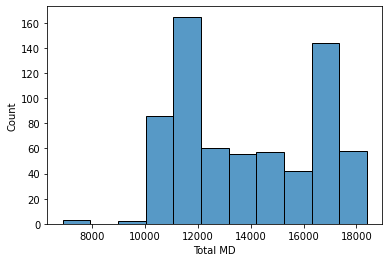

In [37]:
# Histogram of a single variable
sns.histplot(data['Total MD'], kde=False)


<AxesSubplot:xlabel='Total MD'>

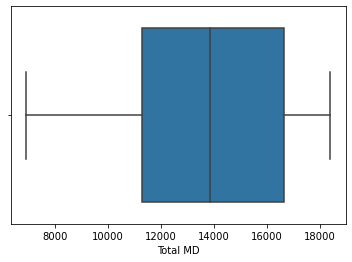

In [60]:
# Boxplot of a single variable
sns.boxplot(x=data['Total MD'])

<AxesSubplot:xlabel='TVD'>

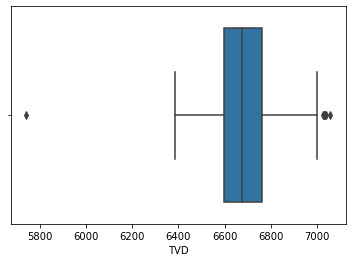

In [38]:
# Boxplot of a single variable
sns.boxplot(x=data['TVD'])


<AxesSubplot:>

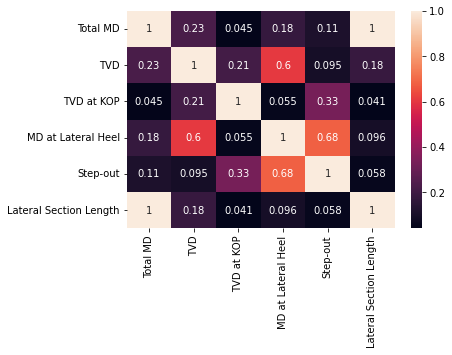

In [39]:
# Correlation matrix of variables
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)

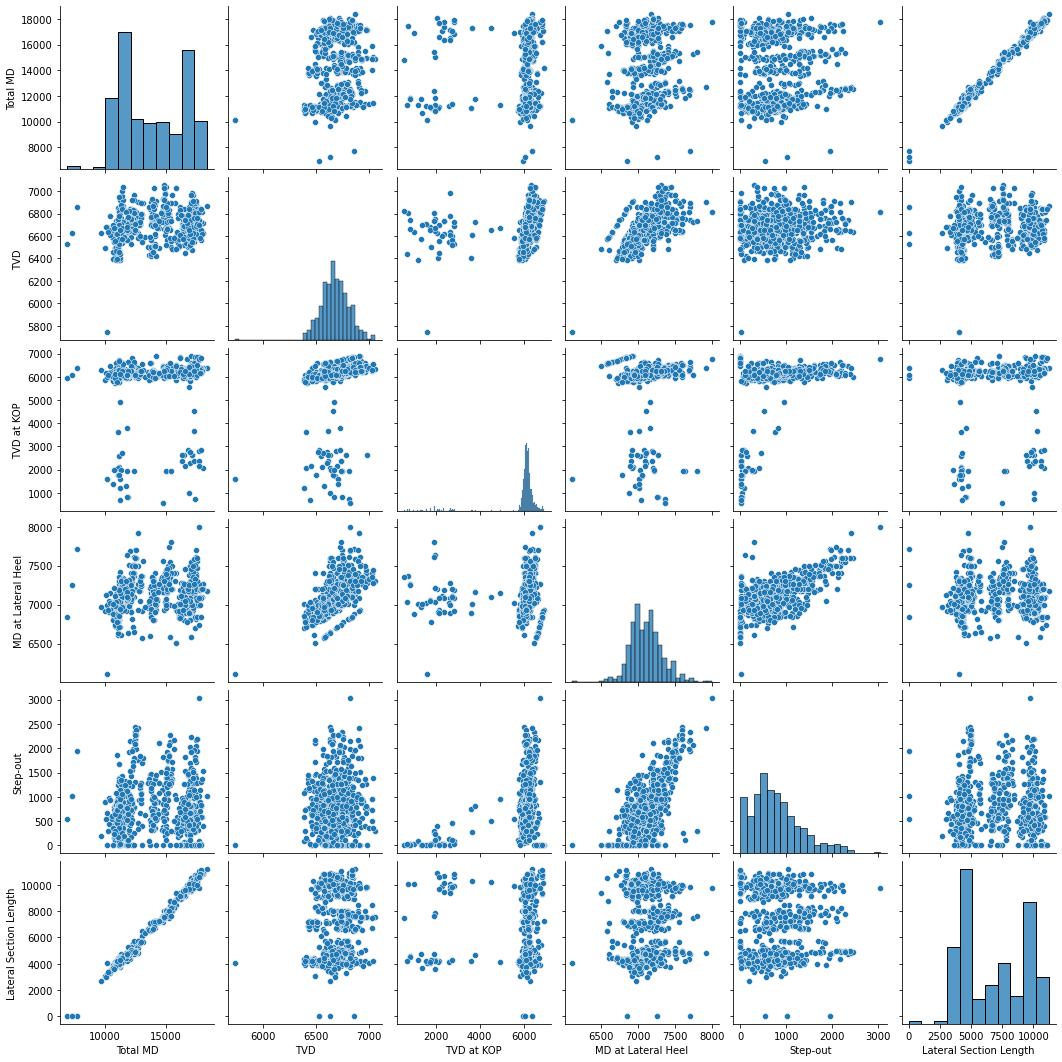

In [40]:
# Pairwise scatterplots of variables
sns.pairplot(data)

## An example of the horizontal wells' trasjectories:

In [41]:
import plotly.graph_objs as go
import pandas as pd

# Create a sample dataframe with three columns representing the x, y, and z coordinates of the points
data = pd.read_excel('Processed Data.xlsx', sheet_name='Processed Surveys Data')
data2 = pd.read_excel('Processed Data.xlsx', sheet_name='Summary of Surveys Data')
df = pd.DataFrame({
   'x': data[data['WellID']==data2['WellID'][60]]['N_S'],
   'y': data[data['WellID']==data2['WellID'][60]]['E_W'],
   'z': data[data['WellID']==data2['WellID'][60]]['TVD_FT']
})

# Create a scatter trace with mode='none' to hide the points
scatter = go.Scatter3d(x=df['x'], y=df['y'], z=df['z'], mode='none')

layout = go.Layout(scene=dict(xaxis_title='N_S',
                              yaxis_title='E_W',
                              zaxis_title='TVD_FT'))

# Create a line trace connecting the points
line = go.Scatter3d(x=df['x'], y=df['y'], z=df['z'], mode='lines')

# Add the scatter and line traces to the figure
fig = go.Figure(data=[scatter, line], layout=layout)

fig.show()

## Linear Regression 


In [42]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# load the data
data = pd.read_excel('Processed Data-latest.xlsx', sheet_name='Summary of Surveys Data')

# extract the three columns of interest
X = data[['Step-out', 'Hook Load', 'Torque']].values
y = data['Lateral Section Length'].values

# create a linear regression model and fit the data
model = LinearRegression()
model.fit(X, y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)


In [43]:
# Train the model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Evaluate the model
y_pred_linear= reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_linear)

r2 = r2_score(y_test, y_pred_linear)


print("Linear Regression:", r2_score(y_test, y_pred_linear))

Linear Regression: 0.9828111041184755


In [44]:
X_combined = np.concatenate((X_train[:,0],X_test[:,0]))
for i in range(len(X_combined)):
    if X_combined[i] < 0:
        X_combined[i] = -X_combined[i]
len(X_combined)

673

In [45]:
y_combined = np.concatenate((y_train,y_pred_linear))
for i in range(len(y_combined)):
    if y_combined[i] < 0:
        y_combined[i] = -y_combined[i]
len(y_combined)

673

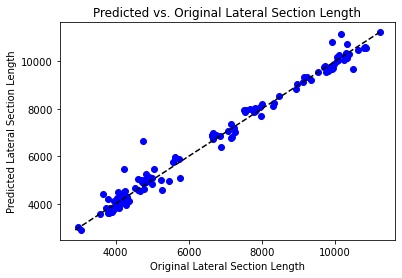

In [46]:
# Plot predicted vs. original data
import numpy as np

# create a numpy array with the same range as the scatter plot
x = np.linspace(min(y_test.min(), y_pred_linear.min()), max(y_test.max(), y_pred_linear.max()))

# plot the 45 degree line
plt.plot(x, x, color='black', linestyle='--')

# plot the scatter plot
plt.scatter(y_test, y_pred_linear, color='blue')
plt.xlabel('Original Lateral Section Length')
plt.ylabel('Predicted Lateral Section Length')
plt.title('Predicted vs. Original Lateral Section Length')
plt.show()



## Random Forest

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
# extract the three columns of interest
X = data[['Step-out', 'Hook Load', 'Torque']].values
y = data['Lateral Section Length'].values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a random forest regression model and fit the data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# predict on test set and evaluate the model
y_pred_rf = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print('Mean squared error:', mse)



Mean squared error: 309430.9184771853


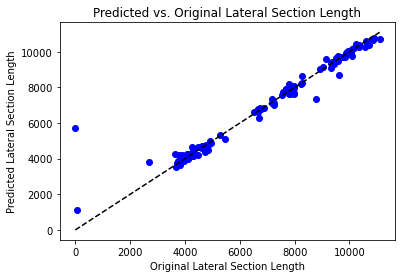

In [49]:
# Plot predicted vs. original data
import numpy as np

# create a numpy array with the same range as the scatter plot
x = np.linspace(min(y_test.min(), y_pred_rf.min()), max(y_test.max(), y_pred_rf.max()))

# plot the 45 degree line
plt.plot(x, x, color='black', linestyle='--')

# plot the scatter plot
plt.scatter(y_test, y_pred_rf, color='blue')
plt.xlabel('Original Lateral Section Length')
plt.ylabel('Predicted Lateral Section Length')
plt.title('Predicted vs. Original Lateral Section Length')
plt.show()


In [50]:
# Calculate R2 score and RMSE for all models
print("R2 Score:")
print("Linear Regression:", r2_score(y_test, y_pred_linear))
print("Random Forest Regression:", r2_score(y_test, y_pred_rf))


R2 Score:
Linear Regression: -0.9693288945759286
Random Forest Regression: 0.9543585097000016


In [51]:
print("\nRMSE:")
print("Linear Regression:", mean_squared_error(y_test, y_pred_linear, squared=False))
print("Random Forest Regression:", mean_squared_error(y_test, y_pred_rf, squared=False))


RMSE:
Linear Regression: 3653.9371369346823
Random Forest Regression: 556.2651512338206


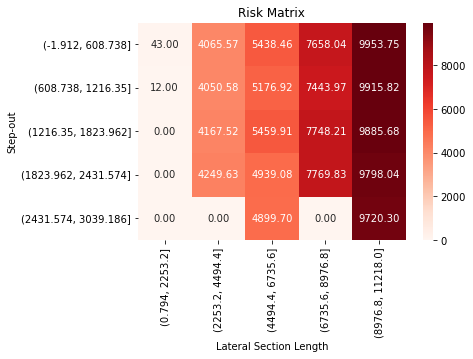

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the data
data = pd.read_excel('Processed Data-latest.xlsx', sheet_name='Summary of Surveys Data')

# filter out rows with negative values
data = data[(data['Step-out'] >= 0) & (data['Lateral Section Length'] >= 0)]

# extract the two columns of interest
step_out = data['Step-out']
lateral_length = data['Lateral Section Length']

# create a pivot table to aggregate the data
pivot_table = pd.pivot_table(data, values='Lateral Section Length', index=pd.cut(step_out, 5), columns=pd.cut(lateral_length, 5), aggfunc='mean',dropna=False, fill_value=0)

# create the heatmap
sns.heatmap(pivot_table, cmap='Reds', annot=True, fmt=".2f")
plt.xlabel('Lateral Section Length')
plt.ylabel('Step-out')
plt.title('Risk Matrix')
plt.show()



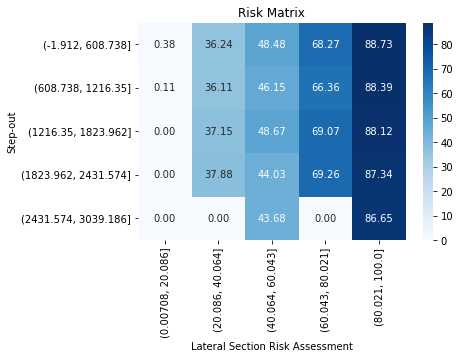

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the data
data = pd.read_excel('Processed Data-latest.xlsx', sheet_name='Summary of Surveys Data')

# filter out rows with negative values
data = data[(data['Step-out'] >= 0) & (data['Lateral Section Length'] >= 0)]

data['Lateral Section Length'] = data['Lateral Section Length']/max(data['Lateral Section Length'])*100

# extract the two columns of interest
step_out = data['Step-out']
lateral_length = data['Lateral Section Length']

# create a pivot table to aggregate the data
pivot_table = pd.pivot_table(data, values='Lateral Section Length', index=pd.cut(step_out, 5), columns=pd.cut(lateral_length, 5), aggfunc='mean',dropna=False, fill_value=0)

# create the heatmap
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".2f")
plt.xlabel('Lateral Section Risk Assessment')
plt.ylabel('Step-out')
plt.title('Risk Matrix')
plt.show()


# Predicted Risk Matrix

In [54]:
y_combined = list(y_combined)
y_combined.pop(-1)
X_combined = list(X_combined)
X_combined.pop(-1)

362.5682403208897

## Lateral Length Optimization:

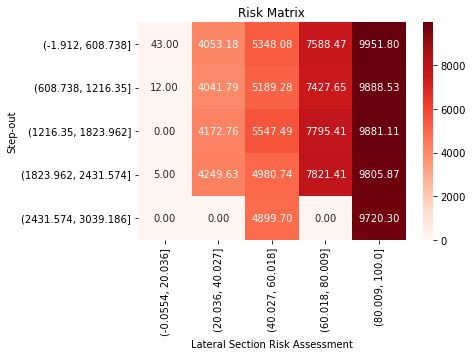

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the data
data = pd.read_excel('Processed Data-latest.xlsx', sheet_name='Summary of Surveys Data')

# filter out rows with negative values
data = data[(data['Step-out'] >= 0) & (data['Lateral Section Length'] >= 0)]

data['Step-out'] = X_combined
data['Lateral Section Length'] = y_combined

# extract the two columns of interest
step_out = data['Step-out']
lateral_length = data['Lateral Section Length']/max(data['Lateral Section Length'])*100

# create a pivot table to aggregate the data
pivot_table = pd.pivot_table(data, values='Lateral Section Length', index=pd.cut(step_out, 5), columns=pd.cut(lateral_length, 5), aggfunc='mean',dropna=False, fill_value=0)

# create the heatmap
sns.heatmap(pivot_table, cmap='Reds', annot=True, fmt=".2f")
plt.xlabel('Lateral Section Risk Assessment')
plt.ylabel('Step-out')
plt.title('Risk Matrix')
plt.show()


## Lateral Length Risk Assessment:

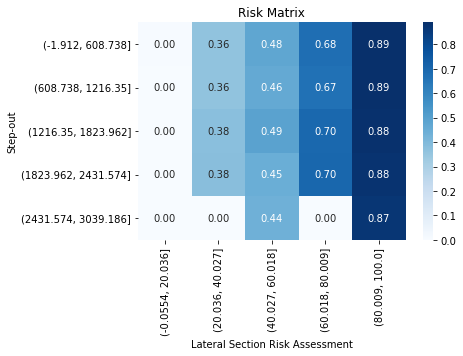

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the data
data = pd.read_excel('Processed Data-latest.xlsx', sheet_name='Summary of Surveys Data')

# filter out rows with negative values
data = data[(data['Step-out'] >= 0) & (data['Lateral Section Length'] >= 0)]

data['Step-out'] = X_combined
for i in range(len(y_combined)):
    y_combined[i] = y_combined[i]/max(y_combined)
data['Lateral Section Length'] = y_combined

# extract the two columns of interest
step_out = data['Step-out']
lateral_length = data['Lateral Section Length']/max(data['Lateral Section Length'])*100

# create a pivot table to aggregate the data
pivot_table = pd.pivot_table(data, values='Lateral Section Length', index=pd.cut(step_out, 5), columns=pd.cut(lateral_length, 5), aggfunc='mean',dropna=False, fill_value=0)

# create the heatmap
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".2f")
plt.xlabel('Lateral Section Risk Assessment')
plt.ylabel('Step-out')
plt.title('Risk Matrix')
plt.show()